In [2]:
import bz2
import pandas as pd
from datetime import datetime, date, time

import seaborn as sns
import matplotlib.pyplot as plt

#NLP libraries
import spacy, nltk

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
path = '/Users/Danae/Documents/Education/Master/Applied Data Analysis (CS-401)/ADA_Group_Projects/ada-2021-project-adagang'

#### Read quote/speaker dataframe

In [4]:
speaker_quotes_total = pd.read_pickle(path + '/total-data-merged.pkl.bz2', compression='bz2')
keys_most_specific = ['all lives matter','black lives matter', 'blue lives matter','campaign zero','movement for black lives',
                      "hands up, don't shoot", 'no justice, no peace','stop killing us','unarmed black man', 'white lives matter']

In [17]:
speaker_quotes_total.head(3)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion
quoteID,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,Jewish people,"[economist, politician, professor, banker]",Republican,None,Ben Bernanke,Judaism


#### Run the sentiment analysis

In [19]:
quotes_sent = speaker_quotes_total.copy() # dataframe to run the sentiment analysis on

analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.head(2)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,sentiment_scores
quoteID,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,0.25
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,0.00


NameError: name 'fig' is not defined

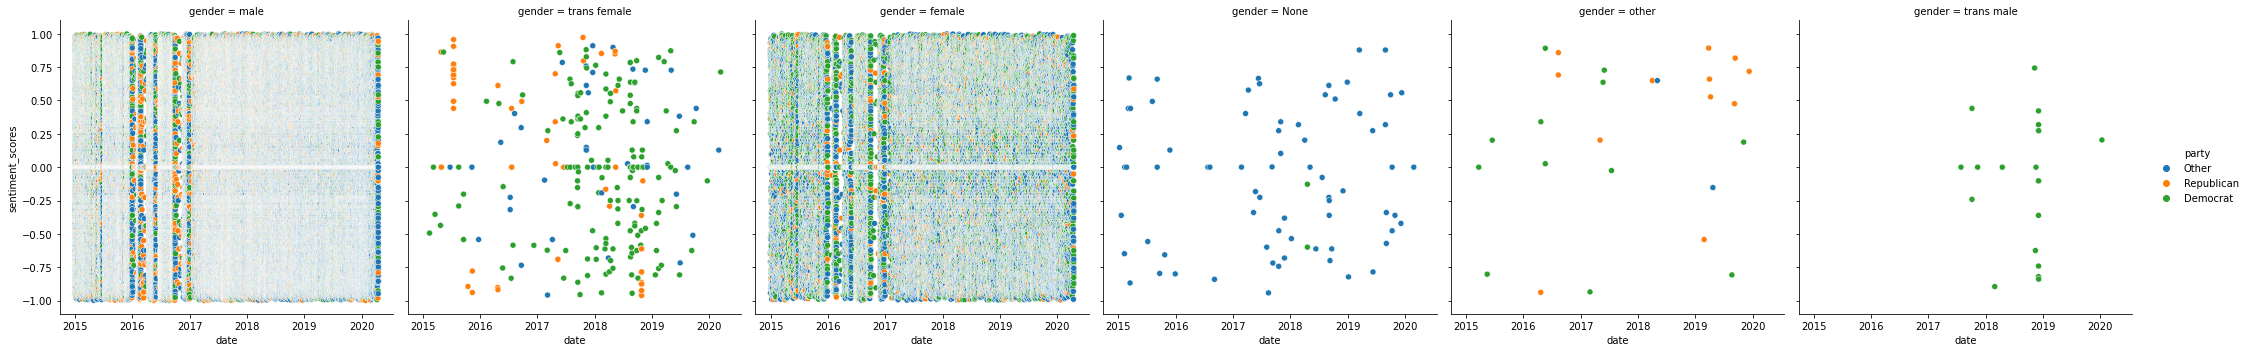

In [20]:
plot_df = quotes_sent.copy().sort_values(by='date')
#plot_df = plot_df.groupby(plot_df['date'].dt.strftime('%Y-%m-%d'))['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", col="gender", hue="party", estimator="mean")
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y %B %d"))
fig.autofmt_xdate()

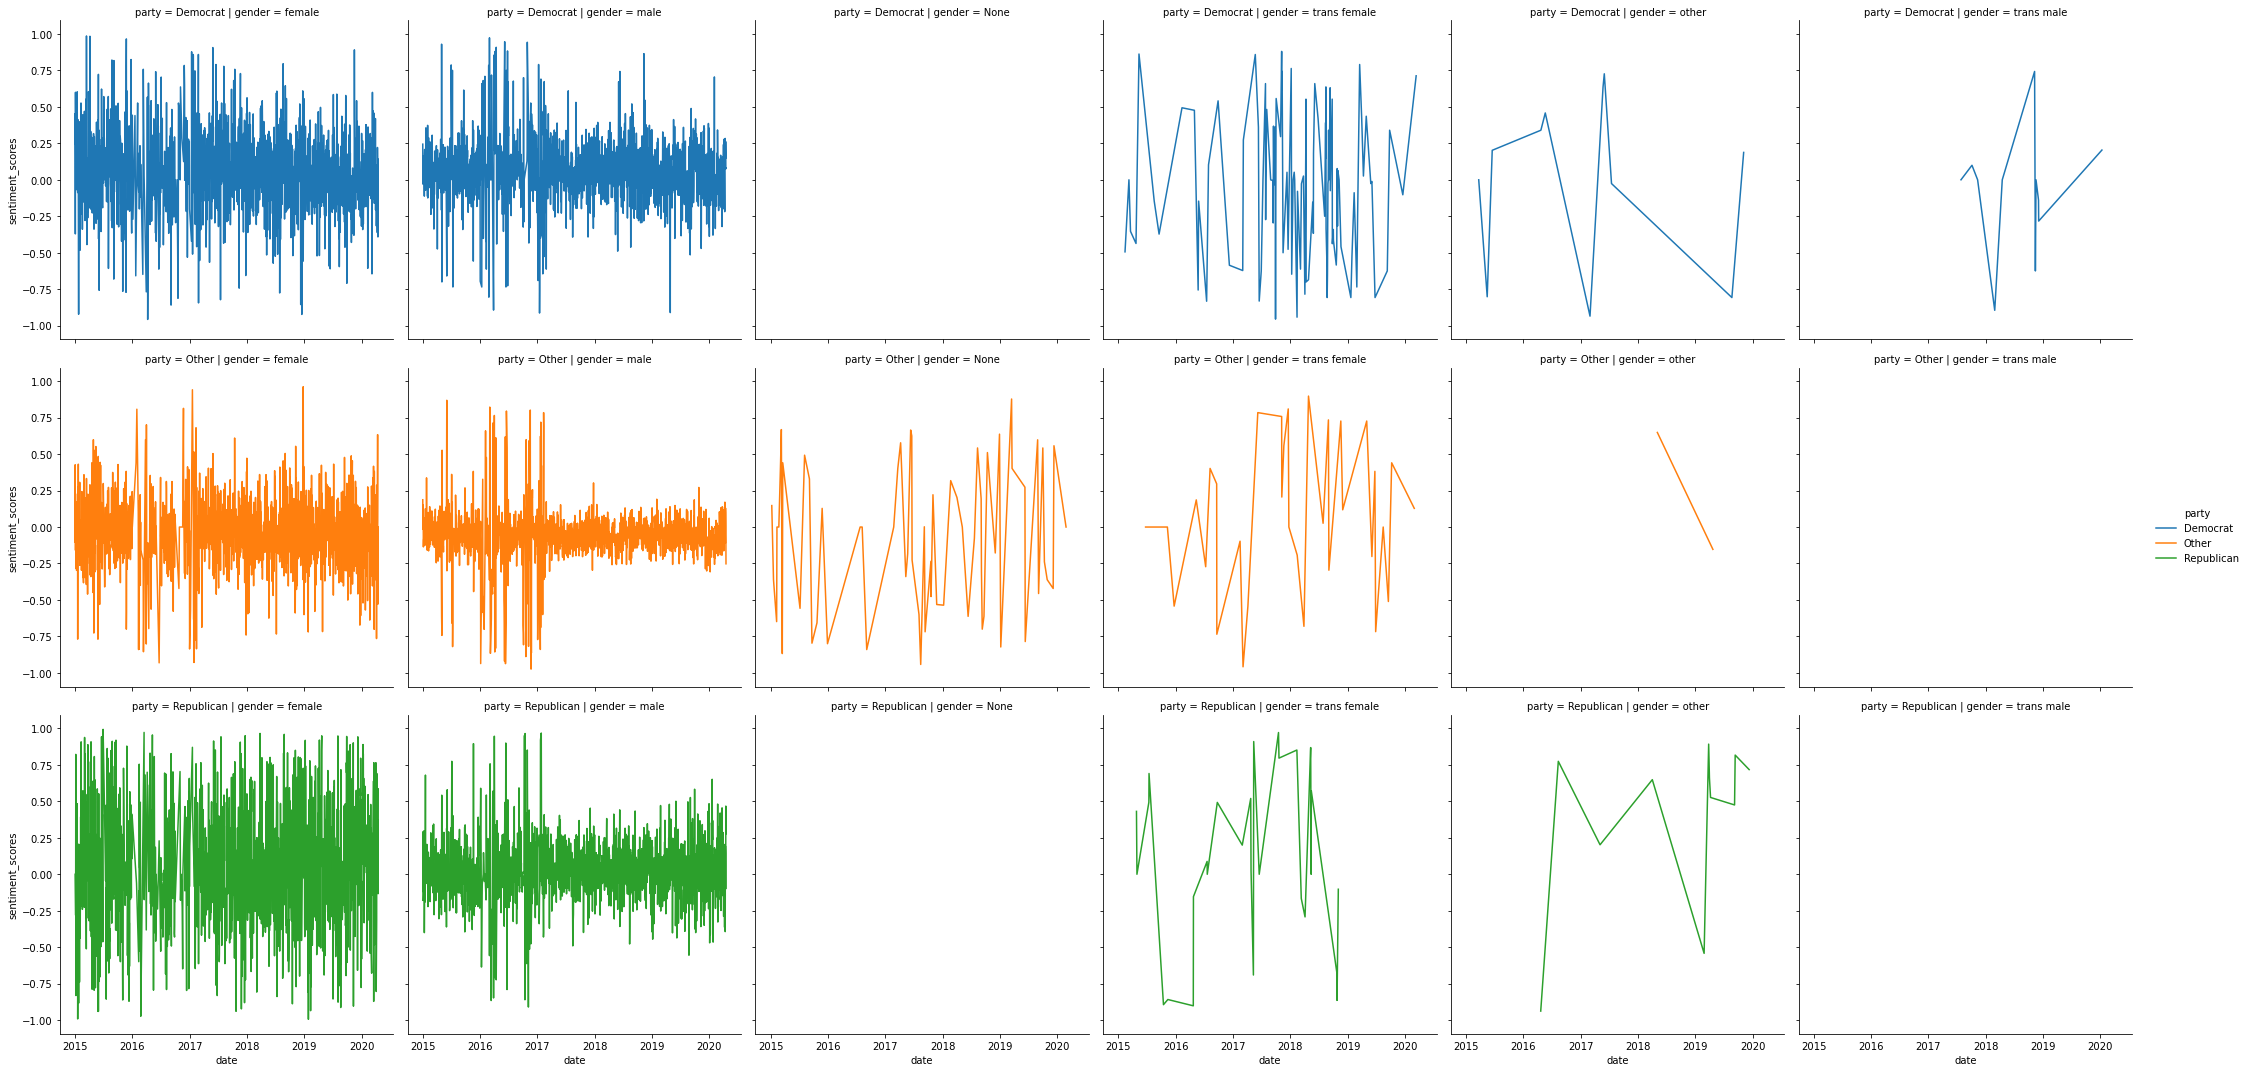

In [21]:
# group by columns and get the average sentiment polarity scores
group_by_cols = ["date", "gender", "party"]
plot_df = quotes_sent.copy().sort_values(by='date')
plot_df = plot_df.groupby(group_by_cols, as_index=False)['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", col="gender", hue="party", kind="line", row="party")
#fig.autofmt_xdate()

#### Named entity recognition

In [22]:
def get_named_entities(df, entity_types):
    ''' Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary. '''
    nlp = spacy.load('en_core_web_sm')
    
    # gets filled with lists of named entities of same type
    entity_dict = {}
    
    for quote in df.quotation:
        doc = nlp(quote)
        
        for ent in doc.ents:
            # if a quote token gets identified as a named entity and its type is included in the list entity_types
            if ent.label_ in entity_types:
                # if a previously identitied named entity was of the same entity type
                if ent.label_ in entity_dict:
                    entity_dict[ent.label_].append(ent.text)
                # if no other named entity identitied before was of the same entity type
                else:
                    entity_dict[ent.label_] = [ent.text]
    
    return entity_dict


def count_dict_entities(entities_dict, entity_types):
    ''' Counts the frequency of the entities in the dictionary. '''
    # gets filled with lists of pairs [entity, number of occurences] of same type
    entity_freq_dict = {}
    
    for key in entities_dict.keys():
        # for every entity of the list
        for ent in entities_dict[key]:
            # if key isn't in the new frequence dictionnary
            if key not in entity_freq_dict.keys():
                entity_freq_dict[key] = [[ent, entities[key].count(ent)]]
            else:
                # if entity has never been seen and counted (not written yet in the freq dictionnary)
                if [ent, entities[key].count(ent)] not in entity_freq_dict[key]:
                    entity_freq_dict[key].append([ent, entities[key].count(ent)])
    
    return entity_freq_dict


def get_entity_type_occurences(entity_type, entity_freq_dict):
    ''' Gets the number of entity occurences for a specific entity type from a frequence dictionary.'''
    ''' Returns a dataframe. '''
    
    # if input key not in input dictionnary, raise error
    if entity_type not in entity_freq_dict.keys():
        raise TypeError(f"{entity_type} isn't an entity_freq_dict key, should be either of these: {entity_freq_dict.keys()}")
    
    # select one entity type
    entity_occ_pairs = entity_freq_dict[entity_type]
    entity_name = []
    entity_occ = []
    
    for pair in entity_occ_pairs:
        entity_name.append(pair[0])
        entity_occ.append(pair[1])
    
    occurences_df = pd.DataFrame(data = { 'entityName' : entity_name,
                                         'numOccurrences' : entity_occ}
                                )
    occurences_df = occurences_df.sort_values(by=['numOccurrences'], ascending=False)

    return occurences_df

In [ ]:
entity_types = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATE']
# Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary
entities = get_named_entities(speaker_quotes_total.copy(), entity_types)
# Counts the frequency of the entities in the dictionary
entity_freq = count_dict_entities(entities, entity_types)
# Gets the number of entity occurences for a specific entity type from a frequence dictionary and returns a dataframe
get_entity_type_occurences('NORP', entity_freq)